In [19]:
# -*- coding: utf-8 -*-
"""
Second Jupyter notebook as a working copy for when the first one is busy scraping

"""

import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter, NelsonAalenFitter
from godwin import Database
import pandasql as ps


db = Database('Godwin.db')
posts = db.get_data()
posts['num_prev_comments'] += 1  # Off-by-one correction
posts['num_prev_comments'].fillna(posts['num_comments'], inplace=True)
posts['failure'] = posts['comment_id'].notnull().astype('int')


qry = '''
        SELECT 
            subreddit, 
            count(comment_id) AS n_failing,
            count(post_id) AS n_total,
            round(100.0*count(comment_id)/count(post_id), 3)
                AS percent_failing,
            round(avg(num_comments), 3) 
                AS avg_comments,
            round(avg(num_prev_comments), 3) 
                AS avg_failure_comments
        FROM posts
        GROUP BY subreddit
        ORDER BY percent_failing DESC;
      '''

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(ps.sqldf(qry, locals()))

,subreddit,n_failing,n_total,percent_failing,avg_comments,avg_failure_comments
0,dankmemes,2,2,100.000,2396.500,45.000
1,politics,76,101,75.248,3627.653,1081.040
2,worldnews,65,101,64.356,2399.693,736.416
3,news,58,101,57.426,3141.832,1527.109
4,PoliticalCompassMemes,57,104,54.808,789.135,360.827
5,AskReddit,52,100,52.000,11876.870,6204.510
6,PublicFreakout,47,101,46.535,2348.574,1088.911
7,todayilearned,46,102,45.098,1453.235,907.794
8,WhitePeopleTwitter,41,103,39.806,1304.184,749.194
9,atheism,38,100,38.000,372.580,231.510


/users/edsouza/.local/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 


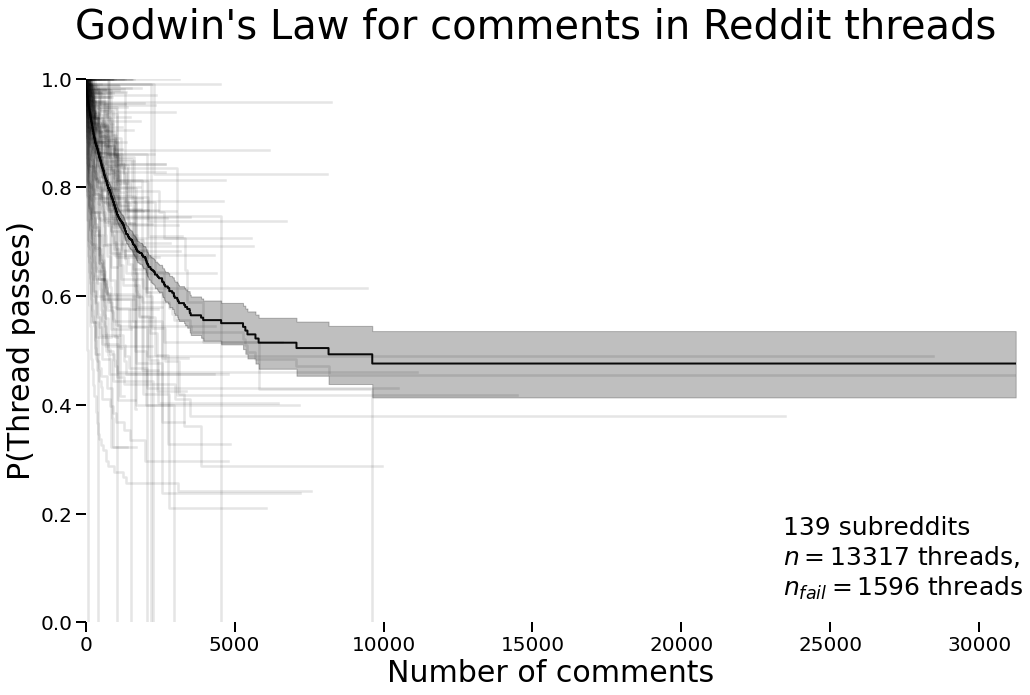

In [39]:
(fig, ax) = plt.subplots(1,1, figsize=(25 * 2/3, 15 * 2/3))

n = posts.shape[0]
n_fail = posts[posts.failure == 1].shape[0]

subs = posts.subreddit.unique()
for sub in subs:
    subset = posts[posts.subreddit == sub]
    kmf = KaplanMeierFitter()
    kmf.fit(subset['num_prev_comments'], event_observed=subset['failure'])
    kmf.plot(alpha=0.1, color='black', lw=2.5,
             ci_show=False, ax=ax)
    plt.xlabel(f'Comments on /r/{sub}')
    
kmf = KaplanMeierFitter()
kmf.fit(posts['num_prev_comments'], event_observed=posts['failure'])
kmf.plot(color='black', alpha=0.95, lw=2, ax=ax)

fig.suptitle(f"Godwin's Law for comments in Reddit threads", fontsize=40)
ax.set_xlabel('Number of comments', fontsize=30)
ax.set_ylabel('P(Thread passes)', fontsize=30)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(direction='out', length=10, width=2, colors='black')

ax.margins(x=0., y=0.)
fig.tight_layout()
ax.get_legend().remove()

samplesize = f"{len(subs)} subreddits\n$n={n}$ threads,\n${'n_{fail}'}={n_fail}$ threads"
plt.text(0.75, 0.05, samplesize, transform=ax.transAxes, fontsize=25)

plt.box(on=None)

# naf = NelsonAalenFitter()
# naf.fit(posts['num_prev_comments'], event_observed=posts['failure'])
# naf.plot_cumulative_hazard(color='black', alpha=0.4, ax=ax)
# naf.plot_hazard(color='red', alpha=0.4, ax=ax, bandwidth=1)

# ax.set_xscale('log', base=10)

<AxesSubplot:xlabel='num_prev_comments', ylabel='failure'>

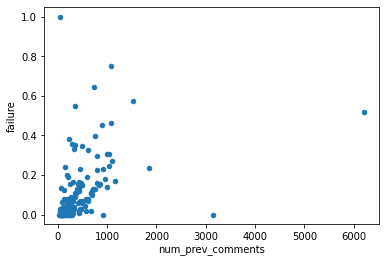

In [21]:
posts.groupby(['subreddit']).mean().plot.scatter('num_prev_comments', 'failure')